In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model,ensemble,metrics,preprocessing
from xgboost import XGBRegressor
from datetime import timedelta

# загрузка данных

In [2]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed = pd.read_csv(url)
confirmed = confirmed.groupby("Country/Region").sum()
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
deaths = pd.read_csv(url)
deaths = deaths.groupby("Country/Region").sum()
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
recovered = pd.read_csv(url)
recovered = recovered.groupby("Country/Region").sum()

In [3]:
confirmed.head()

,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,...,1279,1351,1463,1531,1703,1828,1939,2171,2335,2469
Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,...,663,678,712,726,736,750,766,773,782,789
Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,...,3007,3127,3256,3382,3517,3649,3848,4006,4154,4295
Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,...,723,731,738,738,743,743,743,745,745,747
Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,...,25,25,25,26,27,27,27,27,30,35


In [4]:
confirmed.shape

(187, 104)

график по 5 странам с наибольшим количеством зараженных

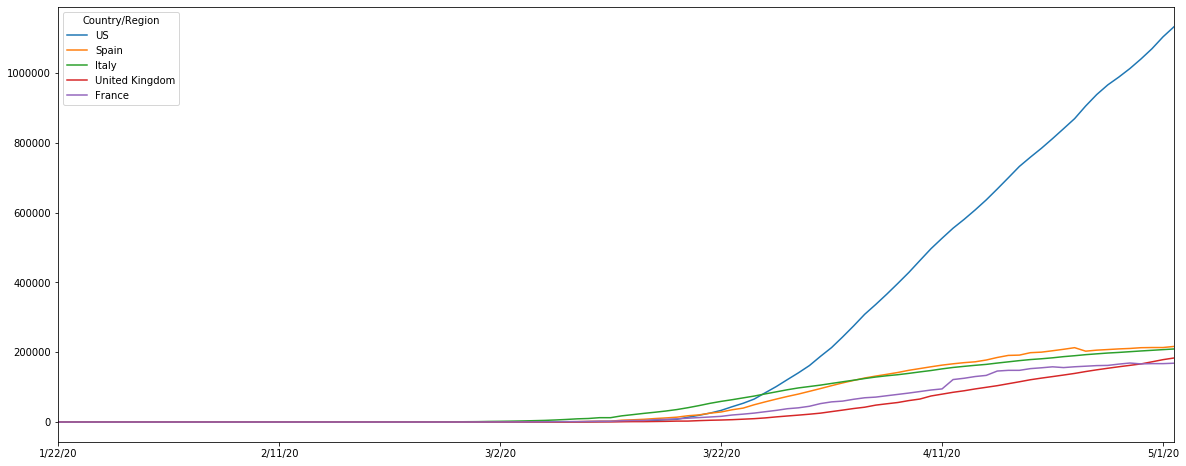

In [5]:
plt.rcParams['figure.figsize'] = [20, 8]
confirmed.sort_values(by=[confirmed.columns[-1]],ascending = False).iloc[:5,2:].T.plot()

соединить таблицы, каждой дате соответствует строка

In [6]:
confirmed = confirmed.iloc[:,2:].stack().reset_index()
confirmed.columns = ['country','date','confirmed']
deaths = deaths.iloc[:,2:].stack().reset_index()
deaths.columns = ['country','date','deaths']
recovered = recovered.iloc[:,2:].stack().reset_index()
recovered.columns = ['country','date','recovered']
cases = confirmed.merge(deaths, how = 'left', left_on=('country','date'), right_on=('country','date'))
cases = cases.merge(recovered, how = 'left', left_on=('country','date'), right_on=('country','date'))
cases['date'] = pd.to_datetime(cases['date'])
cases.head()

,country,date,confirmed,deaths,recovered
0,Afghanistan,2020-01-22,0,0,0
1,Afghanistan,2020-01-23,0,0,0
2,Afghanistan,2020-01-24,0,0,0
3,Afghanistan,2020-01-25,0,0,0
4,Afghanistan,2020-01-26,0,0,0


удалить дни без зараженных

In [7]:
cases = cases[cases['confirmed'] > 5]

## данные о регионах

In [8]:
countries = pd.read_csv('countries.csv')
countries.drop(['iso_alpha2', 'iso_numeric', 'name', 'official_name'], axis='columns', inplace=True)

countries.head()

,iso_alpha3,ccse_name,density,fertility_rate,land_area,median_age,migrants,population,urban_pop_rate,world_share
0,AFG,Afghanistan,60,4.6,652860,18.0,-62920.0,38928346,0.25,0.0050
1,ALB,Albania,105,1.6,27400,36.0,-14000.0,2877797,0.63,0.0004
2,DZA,Algeria,18,3.1,2381740,29.0,-10000.0,43851044,0.73,0.0056
3,AND,Andorra,164,NaN,470,NaN,NaN,77265,0.88,0.0000
4,AGO,Angola,26,5.6,1246700,17.0,6413.0,32866272,0.67,0.0042


In [9]:
countries.isna().sum()

iso_alpha3        0
ccse_name         0
density           0
fertility_rate    6
land_area         0
median_age        6
migrants          6
population        0
urban_pop_rate    5
world_share       0
dtype: int64

удалить пропуски

In [10]:
countries['fertility_rate'] = countries['fertility_rate'].fillna(countries['fertility_rate'].mean())
countries['median_age'] = countries['median_age'].fillna(countries['median_age'].mean())
countries['migrants'] = countries['migrants'].fillna(countries['migrants'].mean())
countries['urban_pop_rate'] = countries['urban_pop_rate'].fillna(countries['urban_pop_rate'].mean())

соединить таблицы

In [11]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!не для всех есть инф-ция по стране
df = cases.merge(countries, how = 'left', left_on='country', right_on='ccse_name')
print(df[df['iso_alpha3'].isna()]['country'].unique())
df = df.dropna(axis='index', how='any')
df.drop(['country'], axis='columns', inplace=True)
df.head()

['Botswana' 'Burma' 'Burundi' 'Diamond Princess' 'Guinea-Bissau' 'Kosovo'
 'MS Zaandam' 'Malawi' 'Mali' 'Saint Kitts and Nevis'
 'Sao Tome and Principe' 'Sierra Leone' 'South Sudan' 'Tajikistan'
 'West Bank and Gaza' 'Western Sahara' 'Yemen']


,date,confirmed,deaths,recovered,iso_alpha3,ccse_name,density,fertility_rate,land_area,median_age,migrants,population,urban_pop_rate,world_share
0,2020-03-11,7,0,0,AFG,Afghanistan,60.0,4.6,652860.0,18.0,-62920.0,38928346.0,0.25,0.005
1,2020-03-12,7,0,0,AFG,Afghanistan,60.0,4.6,652860.0,18.0,-62920.0,38928346.0,0.25,0.005
2,2020-03-13,7,0,0,AFG,Afghanistan,60.0,4.6,652860.0,18.0,-62920.0,38928346.0,0.25,0.005
3,2020-03-14,11,0,0,AFG,Afghanistan,60.0,4.6,652860.0,18.0,-62920.0,38928346.0,0.25,0.005
4,2020-03-15,16,0,0,AFG,Afghanistan,60.0,4.6,652860.0,18.0,-62920.0,38928346.0,0.25,0.005


# новые признаки


'day_n' - счетчик дней с n заболевшего в регионе

In [12]:
day_1 = df[['date','ccse_name']].groupby('ccse_name').min()
df = df.merge(day_1, how = 'left', left_on='ccse_name', right_on='ccse_name',suffixes=('', '_first'))
df['day'] = (df['date'] - df['date_first']).dt.days

'''day_100 = df[df['confirmed'] > 100][['date','ccse_name']].groupby('ccse_name').min()
df = df.merge(day_100, how = 'left', left_on='ccse_name', right_on='ccse_name',suffixes=('', '_100'))
df.fillna((df['date'].iloc[-1]) + timedelta(days=7), inplace = True)
df['day_100'] = (df['date'] - df['date_100']).dt.days
df.loc[df['day_100'] < 0, 'day_100'] = 0

day_10000 = df[df['confirmed'] > 10000][['date','ccse_name']].groupby('ccse_name').min()
df = df.merge(day_10000, how = 'left', left_on='ccse_name', right_on='ccse_name',suffixes=('', '_10000'))
df.fillna((df['date'].iloc[-1]) + timedelta(days=7), inplace = True)
df['day_10000'] = (df['date'] - df['date_10000']).dt.days
df.loc[df['day_10000'] < 0, 'day_10000'] = 0'''

df.head(3)

,date,confirmed,deaths,recovered,iso_alpha3,ccse_name,density,fertility_rate,land_area,median_age,migrants,population,urban_pop_rate,world_share,date_first,day
0,2020-03-11,7,0,0,AFG,Afghanistan,60.0,4.6,652860.0,18.0,-62920.0,38928346.0,0.25,0.005,2020-03-11,0
1,2020-03-12,7,0,0,AFG,Afghanistan,60.0,4.6,652860.0,18.0,-62920.0,38928346.0,0.25,0.005,2020-03-11,1
2,2020-03-13,7,0,0,AFG,Afghanistan,60.0,4.6,652860.0,18.0,-62920.0,38928346.0,0.25,0.005,2020-03-11,2


'confirmed_last' - число заболевших в прошлый день, 
'deaths_last' - число погибших в прошлый день
'_lastN' - N дней назад

In [13]:
df[['confirmed_last','deaths_last','ccse_name']] = df[['confirmed','deaths','ccse_name']].groupby('ccse_name').shift(periods=1, axis='index')
df = df.dropna(axis='index', how='any')

df[['confirmed_last2','deaths_last2','ccse_name']] = df[['confirmed_last','deaths_last','ccse_name']].groupby('ccse_name').shift(periods=1, axis='index')
df = df.dropna(axis='index', how='any')

df[['confirmed_last3','deaths_last3','ccse_name']] = df[['confirmed_last2','deaths_last2','ccse_name']].groupby('ccse_name').shift(periods=1, axis='index')
df = df.dropna(axis='index', how='any')

df[['confirmed_last4','deaths_last4','ccse_name']] = df[['confirmed_last3','deaths_last3','ccse_name']].groupby('ccse_name').shift(periods=1, axis='index')
df = df.dropna(axis='index', how='any')

df[['confirmed_last5','deaths_last5','ccse_name']] = df[['confirmed_last4','deaths_last4','ccse_name']].groupby('ccse_name').shift(periods=1, axis='index')
df = df.dropna(axis='index', how='any')

df.shape
df.head()

,date,confirmed,deaths,recovered,iso_alpha3,ccse_name,density,fertility_rate,land_area,median_age,...,confirmed_last,deaths_last,confirmed_last2,deaths_last2,confirmed_last3,deaths_last3,confirmed_last4,deaths_last4,confirmed_last5,deaths_last5
5,2020-03-16,21,0,1,AFG,Afghanistan,60.0,4.6,652860.0,18.0,...,16.0,0.0,11.0,0.0,7.0,0.0,7.0,0.0,7.0,0.0
6,2020-03-17,22,0,1,AFG,Afghanistan,60.0,4.6,652860.0,18.0,...,21.0,0.0,16.0,0.0,11.0,0.0,7.0,0.0,7.0,0.0
7,2020-03-18,22,0,1,AFG,Afghanistan,60.0,4.6,652860.0,18.0,...,22.0,0.0,21.0,0.0,16.0,0.0,11.0,0.0,7.0,0.0
8,2020-03-19,22,0,1,AFG,Afghanistan,60.0,4.6,652860.0,18.0,...,22.0,0.0,22.0,0.0,21.0,0.0,16.0,0.0,11.0,0.0
9,2020-03-20,24,0,1,AFG,Afghanistan,60.0,4.6,652860.0,18.0,...,22.0,0.0,22.0,0.0,22.0,0.0,21.0,0.0,16.0,0.0


'confirmed_delta' - изменение числа заболевших в прошлый день, 
'deaths_delta' - изменение числа погибших в прошлый день

In [14]:
df['confirmed_delta'] = (df['confirmed'] - df['confirmed_last']).abs()
df['deaths_delta'] = (df['deaths'] - df['deaths_last']).abs()

df['confirmed_delta2'] = (df['confirmed_last'] - df['confirmed_last2']).abs()
df['deaths_delta2'] = (df['deaths_last'] - df['deaths_last2']).abs()

df['confirmed_delta3'] = (df['confirmed_last2'] - df['confirmed_last3']).abs()
df['deaths_delta3'] = (df['deaths_last2'] - df['deaths_last3']).abs()

df['confirmed_delta4'] = (df['confirmed_last3'] - df['confirmed_last4']).abs()
df['deaths_delta4'] = (df['deaths_last3'] - df['deaths_last4']).abs()

df['confirmed_delta5'] = (df['confirmed_last4'] - df['confirmed_last5']).abs()
df['deaths_delta5'] = (df['deaths_last4'] - df['deaths_last5']).abs()

df.loc[:,'day':].head()

,day,confirmed_last,deaths_last,confirmed_last2,deaths_last2,confirmed_last3,deaths_last3,confirmed_last4,deaths_last4,confirmed_last5,...,confirmed_delta,deaths_delta,confirmed_delta2,deaths_delta2,confirmed_delta3,deaths_delta3,confirmed_delta4,deaths_delta4,confirmed_delta5,deaths_delta5
5,5,16.0,0.0,11.0,0.0,7.0,0.0,7.0,0.0,7.0,...,5.0,0.0,5.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
6,6,21.0,0.0,16.0,0.0,11.0,0.0,7.0,0.0,7.0,...,1.0,0.0,5.0,0.0,5.0,0.0,4.0,0.0,0.0,0.0
7,7,22.0,0.0,21.0,0.0,16.0,0.0,11.0,0.0,7.0,...,0.0,0.0,1.0,0.0,5.0,0.0,5.0,0.0,4.0,0.0
8,8,22.0,0.0,22.0,0.0,21.0,0.0,16.0,0.0,11.0,...,0.0,0.0,0.0,0.0,1.0,0.0,5.0,0.0,5.0,0.0
9,9,22.0,0.0,22.0,0.0,22.0,0.0,21.0,0.0,16.0,...,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,0.0


'confirmed/population', 'deaths/population'

In [15]:
df['confirmed/population'] = df['confirmed_last'] / df['population']
df['deaths/population'] = df['deaths_last'] / df['population']
df.shape

(8054, 38)

# модель

In [16]:
def male(y_true, y_score):
    return np.mean(np.abs(np.log10((y_score+1)/(y_true+1))))

In [17]:
feature_list = ['density', 'fertility_rate',
                'land_area', 'median_age',
                'migrants', 'population', 
                'urban_pop_rate', 'world_share', 'day',# 'day_100',
                'confirmed_last',
                'confirmed_last2',
                'confirmed_last3',
                'confirmed_last4',
                'confirmed_last5',
                'confirmed_delta2',
                'confirmed_delta3',
                'confirmed_delta4',
                'confirmed_delta5',
                'confirmed/population']

test_region = 'Russia'

In [18]:
data = df.copy()

scaler = preprocessing.StandardScaler()
data[feature_list] = scaler.fit_transform(data[feature_list])


data_test = data[data['ccse_name'] == test_region]
X_test = data_test[feature_list]
y_c_test = data_test['confirmed_delta']
y_d_test = data_test['deaths_delta']
c_test = data_test['confirmed']
d_test = data_test['deaths']


train = data[(data['ccse_name'] != test_region)]
X = train[feature_list]
y_c = train['confirmed_delta']
y_d = train['deaths_delta']


X.head()

,density,fertility_rate,land_area,median_age,migrants,population,urban_pop_rate,world_share,day,confirmed_last,confirmed_last2,confirmed_last3,confirmed_last4,confirmed_last5,confirmed_delta2,confirmed_delta3,confirmed_delta4,confirmed_delta5,confirmed/population
5,-0.17173,1.95703,-0.118646,-1.734224,-0.499131,-0.106693,-1.949196,-0.106571,-1.408374,-0.190671,-0.189194,-0.187665,-0.186056,-0.184459,-0.193201,-0.192025,-0.191682,-0.189200,-0.339130
6,-0.17173,1.95703,-0.118646,-1.734224,-0.499131,-0.106693,-1.949196,-0.106571,-1.354756,-0.190571,-0.189091,-0.187579,-0.186056,-0.184459,-0.193201,-0.191548,-0.189750,-0.189200,-0.339035
7,-0.17173,1.95703,-0.118646,-1.734224,-0.499131,-0.106693,-1.949196,-0.106571,-1.301138,-0.190551,-0.188987,-0.187472,-0.185966,-0.184459,-0.195073,-0.191548,-0.189268,-0.187246,-0.339016
8,-0.17173,1.95703,-0.118646,-1.734224,-0.499131,-0.106693,-1.949196,-0.106571,-1.247520,-0.190551,-0.188966,-0.187364,-0.185854,-0.184366,-0.195541,-0.193453,-0.189268,-0.186757,-0.339016
9,-0.17173,1.95703,-0.118646,-1.734224,-0.499131,-0.106693,-1.949196,-0.106571,-1.193901,-0.190551,-0.188966,-0.187342,-0.185743,-0.184250,-0.195541,-0.193929,-0.191199,-0.186757,-0.339016


In [19]:
#model_c = linear_model.Lasso().fit(X, y_c)
#model_d = linear_model.Lasso().fit(X, y_d)

#model_c = ensemble.RandomForestRegressor(n_estimators = 500, max_depth = 30).fit(X, y_c)
#model_d = ensemble.RandomForestRegressor(n_estimators = 500, max_depth = 30).fit(X, y_d)

model_c = XGBRegressor(objective ='reg:squarederror',n_estimators=500, max_depth=30).fit(X, y_c)
#model_d = XGBRegressor(objective ='reg:squarederror',n_estimators=500, max_depth=30).fit(X, y_d)

In [20]:
pred_c = model_c.predict(X_test)
#pred_d = model_d.predict(X_test)
print('MALE confirmed: ', male(y_c_test, pred_c))
#print('MALE deaths: ', male(y_d_test, pred_d))

MALE confirmed:  0.20798114103980297


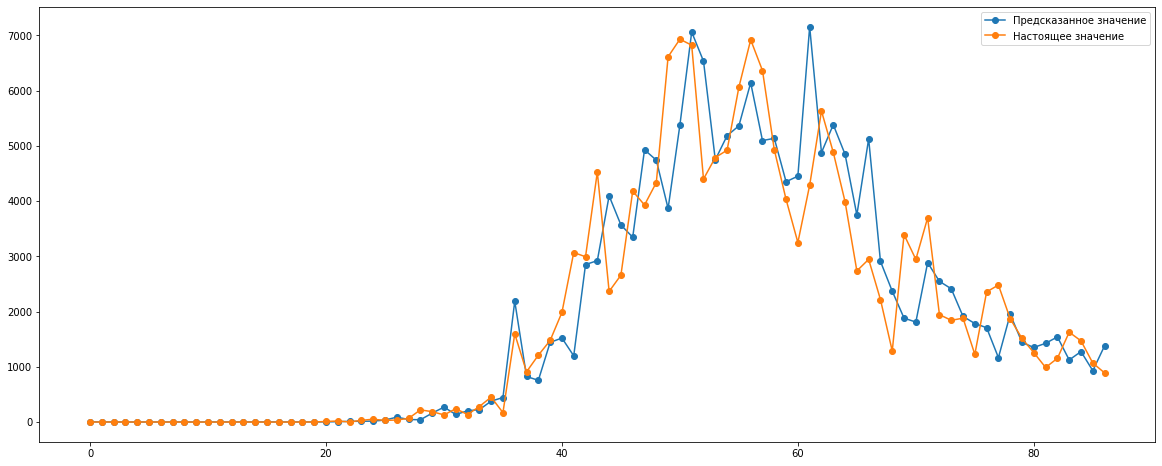

In [21]:
fig, ax = plt.subplots()
x = list(range(len(pred_c)))
ax.plot(x, pred_c, marker='o', label = "Предсказанное значение") 
ax.plot(x, y_c_test, marker='o', label = "Настоящее значение") 
ax.legend()

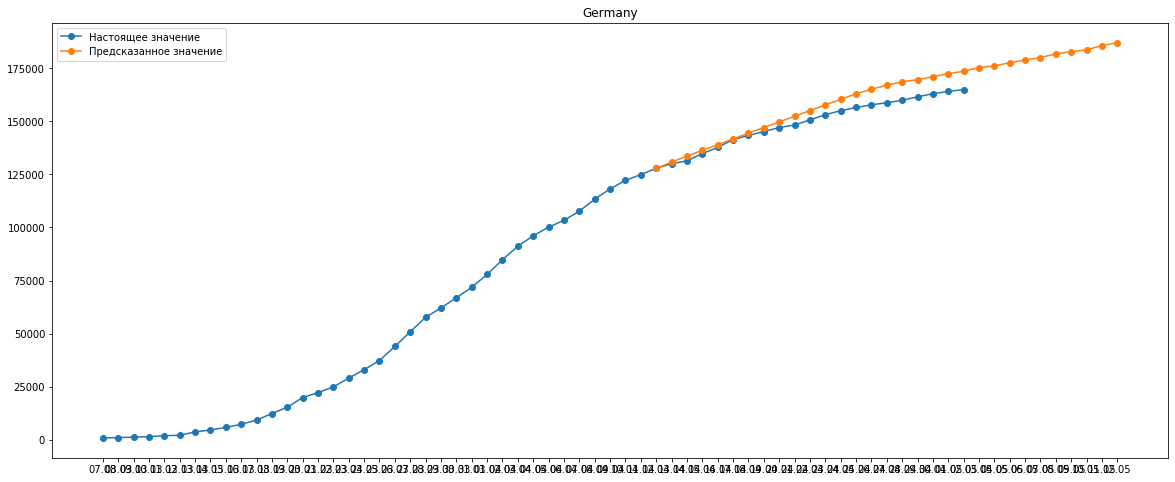

In [27]:
#построить прогноз на N_DAYS дней

N_DAYS = 30
LAG = 20
PLOT_FIRST_DAY = 30

X1 = pd.DataFrame(X_test.iloc[-1-LAG]).T
C = []
D = []
c = [y_c_test.iloc[-1-LAG]]

for i in range(N_DAYS+1):
    #print(X1)
    
    X1[:] = scaler.inverse_transform(X1[:])
    C.append(X1.iloc[0]['confirmed_last'] + c[0])
    #D.append(X1.iloc[0]['deaths_last'] + d[0])

    X1['day'] += 1
    
    X1.iloc[0]['confirmed_last5'] = X1.iloc[0]['confirmed_last4']
    #X1.iloc[0]['deaths_last5'] = X1.iloc[0]['confirmed_last4']
    
    X1.iloc[0]['confirmed_last4'] = X1.iloc[0]['confirmed_last3']
    #X1.iloc[0]['deaths_last4'] = X1.iloc[0]['confirmed_last3']
    
    X1.iloc[0]['confirmed_last3'] = X1.iloc[0]['confirmed_last2']
    #X1.iloc[0]['deaths_last3'] = X1.iloc[0]['confirmed_last2']
    
    X1.iloc[0]['confirmed_last2'] = X1.iloc[0]['confirmed_last']
    #X1.iloc[0]['deaths_last2'] = X1.iloc[0]['confirmed_last']
    
    X1.iloc[0]['confirmed_last'] += c[0]
    #X1.iloc[0]['deaths_last'] += d[0]
    
    X1.iloc[0]['confirmed_delta5'] = X1.iloc[0]['confirmed_delta4']
    #X1.iloc[0]['deaths_delta5'] = X1.iloc[0]['deaths_delta4']
    
    X1.iloc[0]['confirmed_delta4'] = X1.iloc[0]['confirmed_delta3']
    #X1.iloc[0]['deaths_delta4'] = X1.iloc[0]['deaths_delta3']
    
    X1.iloc[0]['confirmed_delta3'] = X1.iloc[0]['confirmed_delta2']
    #X1.iloc[0]['deaths_delta3'] = X1.iloc[0]['deaths_delta2']
    
    X1.iloc[0]['confirmed_delta2'] = c[0]
    #X1.iloc[0]['deaths_delta2'] = d[0]
    
    X1['confirmed/population'] = X1['confirmed_last'] / X1['population']
    #X1['deaths/population'] = X1['deaths_last'] / X1['population']

    X1[:] = scaler.transform(X1[:])
    
    c = model_c.predict(X1)
    #d = model_d.predict(X1)

#график
fig, ax = plt.subplots()
#x1 = list(range(len(c_test[PLOT_FIRST_DAY:])))
x1 = data_test['date'].apply(lambda x: x.strftime("%d.%m")).values[PLOT_FIRST_DAY:]
#x2 = np.array(range(N_DAYS+1)) + len(x1) - LAG - 1
x2 = pd.date_range(data_test['date'].iloc[-1-LAG], data_test['date'].iloc[-1-LAG] + timedelta(days=N_DAYS)).strftime("%d.%m")
ax.plot(x1, c_test[PLOT_FIRST_DAY:], marker='o', label = "Настоящее значение") 
ax.plot(x2, C, marker='o', label = "Предсказанное значение")
ax.set_title(test_region)
ax.legend()
plt.show()